In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


In [2]:
#Read genome sequence file

genome_sequence = ''
with open('NC_011297.fna', 'r') as f :
    f.readline()
    
    for line in f :
        genome_sequence += line.strip()

print('genome length = ' + str(len(genome_sequence)))

genome length = 1959987


In [3]:
# Problem 2.1 - 2.2

# Takes as input the emission sequence (genome) and probability parameters
# Outputs the most likely state sequence using Viterbi decoding
# Emissions are observations.
def viterbi_decode(emissions, initial_probilites, transition_probilites, emission_probilities):
    T = len(emissions)
    backtrack = np.zeros((2, len(emissions)), dtype="int")
    states_labeled = np.zeros(len(emissions), dtype="int")
    max_states_logprob = 0
    max_states = [0] * T
    
    
    
    # using log probabilities is computationally more efficient.
    initial_probilities_log = np.log(initial_probilites)
    transition_probilities_log = np.log(transition_probilites)
    emission_probilities_log = np.log(emission_probilities)
    
    # Bad code design, remove from here. Make input emissions: 1, 2, 3, 4.
    state_given_emission_table = {'A': np.log(emission_probilities[:, 0]), \
                                  'C': np.log(emission_probilities[:, 1]), \
                                  'G': np.log(emission_probilities[:, 2]), \
                                  'T': np.log(emission_probilities[:, 3]) }
    
    length_emissions = len(emissions)
    length_hidden_vlaues = emission_probilities.shape[0]
    
    # Implement the Viterbi decoding algorithm
    # Store the decoded state sequence in 'max_states'
    # Store the state sequence log likelihood in 'max_states_logprob'   
    probility_matrix_log = np.zeros((length_hidden_vlaues,length_emissions))
    probility_matrix_log[:, 0] = initial_probilities_log + state_given_emission_table[emissions[0]]
    
    for i in range(1, length_emissions):
        candidates0 = probility_matrix_log[:, i - 1] + transition_probilities_log[:, 0]
        current_transition_probability0 = max(candidates0)
        amax0 = np.argmax(candidates0)
        
        candidates1 = probility_matrix_log[:, i - 1] + transition_probilities_log[:, 1]
        current_transition_probability1 = max(candidates1)
        amax1 = np.argmax(candidates1)
        
        current_transition_probability = [current_transition_probability0, current_transition_probability1]
        probility_matrix_log[:, i] = current_transition_probability + state_given_emission_table[emissions[i]]
            
        backtrack[:, i] = [amax0, amax1]
        i = i + 1
    
    
    states_labeled[length_emissions - 1] = np.argmax(probility_matrix_log[:, length_emissions - 1])
    for i in range(1, length_emissions):
        backwardIdx = length_emissions - i  - 1
        states_labeled[backwardIdx] = backtrack[states_labeled[backwardIdx + 1], backwardIdx]
    
    max_end_logprob = np.max(probility_matrix_log[:, length_emissions - 1])
    
    return max_end_logprob, states_labeled

# Takes as input the emission sequence (genome) and probability parameters
# Outputs new (re-estimated) probability parameters
# Implement Viterbi training to re-estimate parameters
# Store the new parameters in the 'new_' matrices
# Store the Viterbi-decoded state sequence log likelihood in 'log_probs' at each iteration of training
def viterbi_train(emissions, initial_probilites, transition_probilites, emission_probilities, iterations = 10):
    given_probabilities = {'A': {0: 0, 1: 0}, 'C': {0: 0, 1: 0} , 'G': {0: 0, 1: 0} , 'T': {0: 0, 1: 0} }
    
    new_transition_probilites = transition_probilites
    new_emission_probilities = emission_probilities
    max_log_probilities = []
    
    for i in range(iterations):
        max_end_logprob, states_labeled \
        = viterbi_decode(emissions, initial_probilites, new_transition_probilites, new_emission_probilities)
        
        max_log_probilities.append(max_end_logprob)
        
        for i in range(len(emissions)):
            given_probabilities[emissions[i]][states_labeled[i]] = \
                given_probabilities[emissions[i]][states_labeled[i]] + 1
    
        log_probs = np.array([given_probabilities[key] for key in ('A', 'C', 'G', 'T')]).T

        log_probs_array = np.zeros((2, 4))
        for i in range(len(log_probs)):
            log_probs_array[:, i] = np.fromiter(log_probs[i].values(), dtype = float)

        new_emission_probilities = normalize(log_probs_array, norm = "l1", axis = 1)

        transition_count = {'00': 0, '01': 0 , '10': 0 , '11': 0}

        for i in range(1, len(states_labeled)):
            transition = str(states_labeled[i - 1]) + str(states_labeled[i])
            transition_count[transition] = transition_count[transition] + 1

        new_transition_probilites = np.array([transition_count[key] for key in ('00', '01', '10', '11')]).T
        new_transition_probilites = np.reshape(new_transition_probilites, (2, 2))
        new_transition_probilites = normalize(new_transition_probilites, norm = "l1", axis = 1)
    
    return max_log_probilities, initial_probilites, new_emission_probilities, new_transition_probilites


In [4]:
# Problem 2.1
# Here we initialize the probability matrices for the HMM

# Initialize P(s_{1})
initial_probabilities = np.array([0.996, 0.004])

# Initialize P(s_{t} | s_{t-1})
transition_probabilities = np.array([
    [0.999, 0.001], # s_{t-1} = AT
    [0.01, 0.99] # s_{t-1} = GC
])

# A C G T
# Initialize P(o_{t} | s_{t})
emission_probabilities = np.array([
    [0.291, 0.209, 0.209, 0.291], # s_{t} = AT
    [0.169, 0.331, 0.331, 0.169] # s_{t} = GC
])

In [5]:
# Problem 2.1
# Run Viterbi decoding to obtain the most likely state sequence for the genome
max_end_logprob, states_labeled = \
viterbi_decode(genome_sequence, initial_probabilities, transition_probabilities, emission_probabilities)

The ratio between GC occurrence to the whole genome is:0.005592384031118574
The maximum probability becomes: -2609763.3301350856


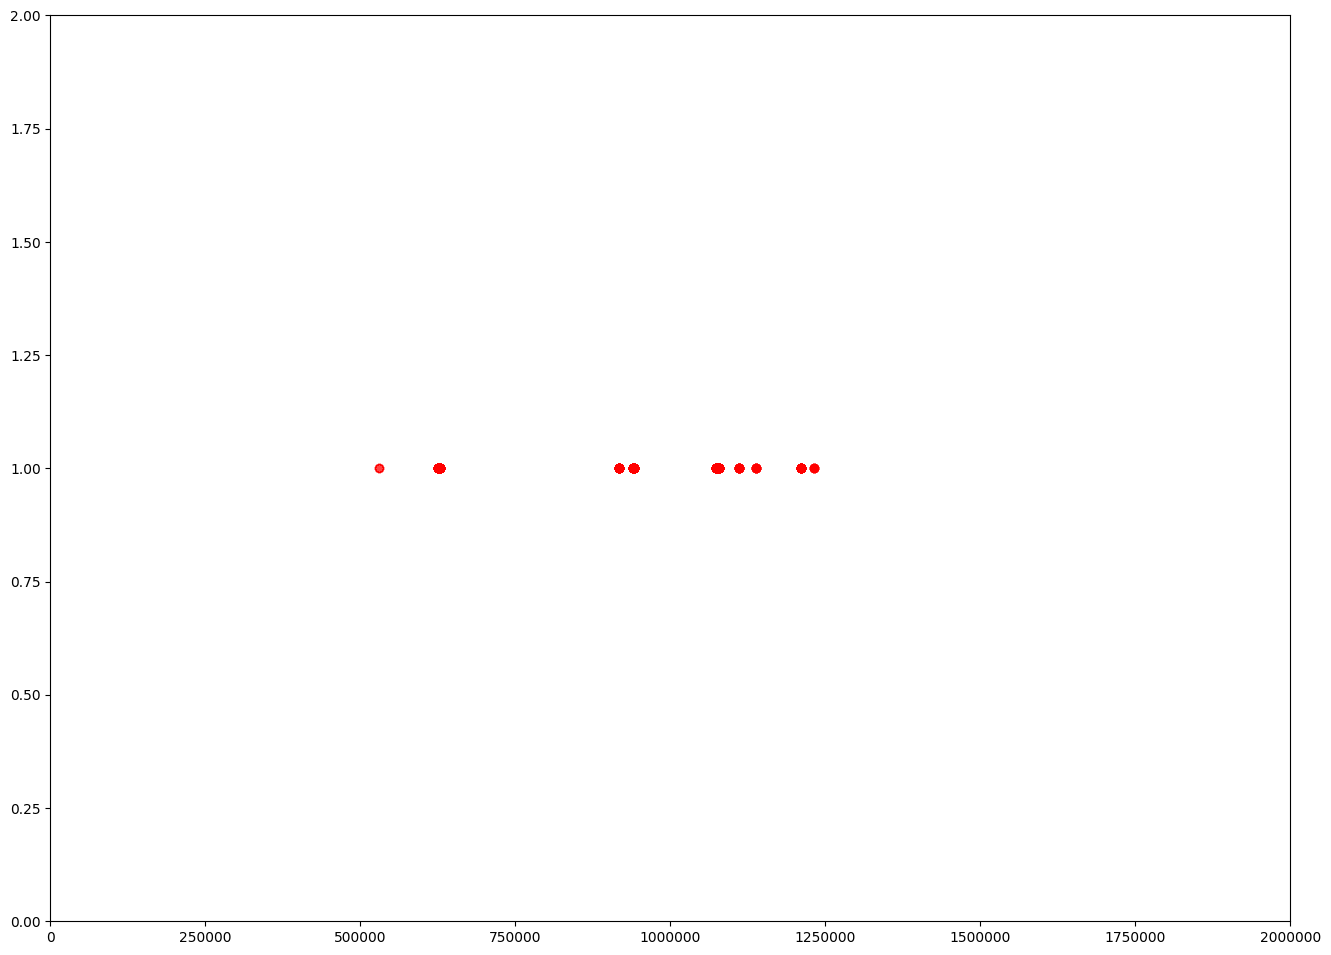

In [15]:
# Problem 2.1
# Plot the genomic nucleotide coordinates of detected GC-rich regions
plt.figure(figsize=(16, 12), dpi = 100)
indices = np.where(states_labeled == 1)
plt.scatter(indices, states_labeled[states_labeled == 1], alpha = 0.01, color = "red")
plt.axis([0, 2000000, 0, 2])
plt.plot()
print("The ratio between GC occurrence to the whole genome is:" + str(len(indices[0]) / len(genome_sequence)))
print("The maximum probability becomes: " + str(max_end_logprob))

In [7]:
# Problem 2.2
# Update HMM parameters with Viterbi training
max_end_log_probabilities, initial_probabilities, new_emission_probabilities, new_transition_probabilities \
= viterbi_train(genome_sequence, initial_probabilities,\
                transition_probabilities, emission_probabilities, iterations = 10)

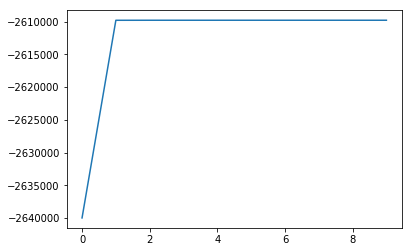

In [8]:
# Plot genome sequence (emission sequence) likelihood vs. EM iteration
plt.plot(range(0, len(max_end_log_probabilities)), max_end_log_probabilities)

In [9]:
# Problem 2.2
# Re-run viterbi decoding with the new probability parameters.
max_end_logprob, new_states_labeled \
= viterbi_decode(genome_sequence, initial_probabilities, new_transition_probabilities, new_emission_probabilities)

The ratio between GC occurrence to the whole genome is:0.007284231987252977
The maximum probability becomes: -2609763.3301350856


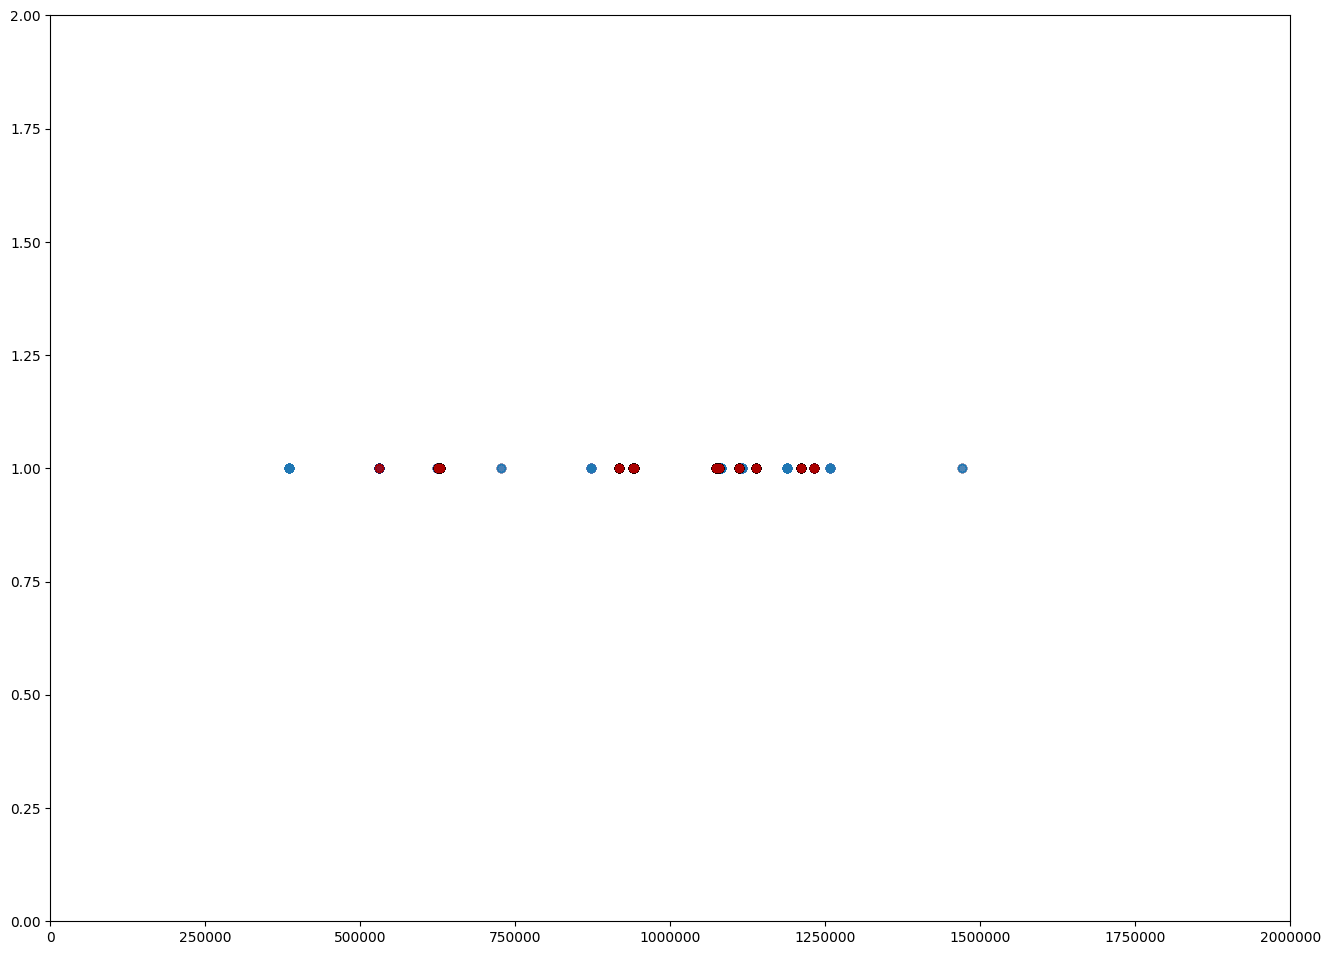

In [16]:
# Problem 2.2
# Plot the genomic coordinates of newly detected GC-rich regions along with the previous detected regions
plt.figure(figsize=(16, 12), dpi = 100)
new_indices = np.where(new_states_labeled == 1)
plt.scatter(new_indices, new_states_labeled[new_states_labeled == 1], alpha = 0.01)
plt.scatter(indices, states_labeled[states_labeled == 1], alpha = 0.01, color = "red")
plt.axis([0, 2000000, 0, 2])
plt.plot()
print("The ratio between GC occurrence to the whole genome is:" + str(len(new_indices[0]) / len(genome_sequence)))
print("The maximum probability becomes: " + str(max_end_logprob))

We can definitely see the change here after the training all the blue points are the result of the EM algorithm.
We can aslo see how the percentage of the GC areas increased from 0.56% to 0.73% of the whole sequence. 